**Pytorch setup**

In [10]:
#importing the pytorch library
import torch

#pytorch version and device
print("Pytorch version", torch.__version__)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("using device:", device)

#create & inspect tensors
t1 = torch.tensor([[1,2],[3,4]] , dtype = torch.float32)
t2 = torch.rand(2,2)
print("t1:" , t1, "shape:", t1.shape)
print("t2:", t2)

#Basic ops
print("Add:", t1 + t2)
print("MatMul:", t1 @ t2) #note "@" is for matric multiplication only

#Move to GPU if available
t1_gpu = t1.to(device)
print("t1 on", t1_gpu.device)


Pytorch version 2.7.1
using device: cpu
t1: tensor([[1., 2.],
        [3., 4.]]) shape: torch.Size([2, 2])
t2: tensor([[0.0889, 0.2687],
        [0.3784, 0.9293]])
Add: tensor([[1.0889, 2.2687],
        [3.3784, 4.9293]])
MatMul: tensor([[0.8457, 2.1274],
        [1.7803, 4.5234]])
t1 on cpu


In [11]:
#Importing torch vision library 
from torchvision import transforms, datasets
import matplotlib.pyplot as plt

#function to transform data to tensors
transform = transforms.ToTensor()

#Download MNIST Dataset
train_ds = datasets.MNIST(root ="data", train = True, download=True, transform=transform)
test_ds =  datasets.MNIST(root = "data", train = False,download=True, transform=transform )
print("Train size:", len(train_ds) , "test size::", len(test_ds))

Train size: 60000 test size:: 10000


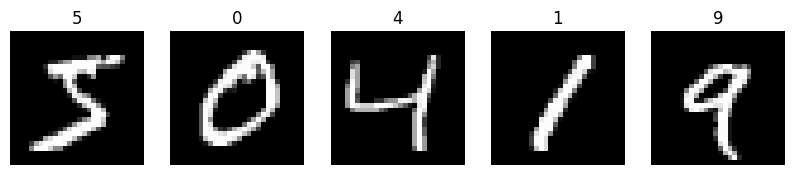

single image shape: torch.Size([1, 28, 28])


In [12]:
#visualizing some samples with Matplotlib
fig, axes = plt.subplots(1,5, figsize=(10,2))
for i, ax in enumerate(axes):
    img, label = train_ds[i]
    ax.imshow(img.squeeze(), cmap="gray")
    ax.set_title(label)
    ax.axis(False)
plt.show()

#checking tensor shape
img, label = train_ds[0]
print("single image shape:", img.shape)

batch images torch.Size([64, 1, 28, 28])
batch labels torch.Size([64])


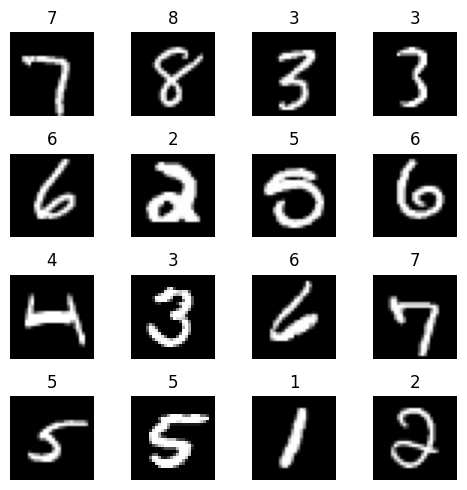

In [13]:
#Import Data loader
from torch.utils.data import DataLoader

BATCH_SIZE = 64

#Create batch loaders
train_loader = DataLoader(train_ds, batch_size= BATCH_SIZE, shuffle = True)
test_loader = DataLoader(test_ds,  batch_size = BATCH_SIZE)

#Inspect one batch
images, labels = next(iter(train_loader))
print("batch images", images.shape)
print("batch labels", labels.shape)

#plot a 4 X 4 grid from batch
fig, axes = plt.subplots (4,4, figsize=(5,5))
for i, ax in enumerate(axes.flatten()):
    ax.imshow(images[i].squeeze(), cmap="gray")
    ax.set_title(int(labels[i]))
    ax.axis(False)
plt.tight_layout()
plt.show()

**BUILDING THE MULTI-LAYER PERCEPTRON**

In [14]:
#importing modules
import torch
import torch.nn as nn 
import torch.nn.functional as f 
import torchvision 
import torchvision.transforms as transforms

#load MNIST data and dataloader
transform = transforms.Compose([transforms.ToTensor()])
train_data = torchvision.datasets.MNIST(root='.data/' ,train = True, download= True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True)

#Define the multi layer perceptron model
model = nn.Sequential(
    nn.Flatten(),
    nn.Linear(784,128),
    nn.ReLU(),
    nn.Linear(128,64),
    nn.ReLU(),
    nn.Linear(64,10)
)

#print model summary
print(model)

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=128, bias=True)
  (2): ReLU()
  (3): Linear(in_features=128, out_features=64, bias=True)
  (4): ReLU()
  (5): Linear(in_features=64, out_features=10, bias=True)
)


In [15]:
#Choosing a loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)


from torchsummary import summary
summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                  [-1, 128]         100,480
              ReLU-3                  [-1, 128]               0
            Linear-4                   [-1, 64]           8,256
              ReLU-5                   [-1, 64]               0
            Linear-6                   [-1, 10]             650
Total params: 109,386
Trainable params: 109,386
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.42
Estimated Total Size (MB): 0.43
----------------------------------------------------------------


**BUILDING TRAINING LOOP**

In [16]:

def train_one_epoch(model, dataloader, loss_fn, optimizer, device):
    model.train()
    running_loss, running_corrects, total = 0.0, 0, 0

    for X_batch, y_batch in dataloader:                           #loop through data in barch
        X_batch, y_batch = X_batch.to(device), y_batch.to(device) #move data to right device

        optimizer.zero_grad()                                    #clear out gradient for every parameter(.grad) before a new iteration
        logits = model(X_batch)                                  # make predictions on input
        loss = loss_fn(logits, y_batch)                
        loss.backward()                                          #calculate all the gradients for parameters using back propagation
        optimizer.step()                                         #updates the parameter values with the adam optimizer

        # accumulate stats
        running_loss += loss.item() * X_batch.size(0)
        preds = torch.argmax(logits, dim=1)
        running_corrects += (preds == y_batch).sum().item()
        total += X_batch.size(0)

    epoch_loss = running_loss / total
    epoch_acc  = running_corrects / total
    return epoch_loss, epoch_acc


In [17]:
def evaluate(model, dataloader, loss_fn, device):
    model.eval()
    val_loss, val_corrects, total = 0.0, 0, 0

    with torch.no_grad():
        for X_batch, y_batch in dataloader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            logits = model(X_batch)
            loss = loss_fn(logits, y_batch)

            val_loss += loss.item() * X_batch.size(0)
            preds = torch.argmax(logits, dim=1)
            val_corrects += (preds == y_batch).sum().item()
            total += X_batch.size(0)

    epoch_loss = val_loss / total
    epoch_acc  = val_corrects / total
    return epoch_loss, epoch_acc   

In [18]:
#running short training loop

import torch , time
from torch.utils.data import DataLoader

device = torch.device('cpu')  # or 'cuda' if you have a GPU

train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
test_loader  = DataLoader(test_ds,  batch_size=64, shuffle=False)

num_epochs = 5
history = {'train_loss':[], 'train_acc':[], 'val_loss':[], 'val_acc':[]}

start = time.time()

for epoch in range(1, num_epochs+1):
    train_loss, train_acc = train_one_epoch(model, train_loader, loss_fn, optimizer, device)
    val_loss,   val_acc   = evaluate(model, test_loader,    loss_fn, device)

    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)

    print(f"Epoch {epoch}/{num_epochs}"
          f" — Train: loss={train_loss:.4f}, acc={train_acc:.4f}"
          f" — Val:   loss={val_loss:.4f}, acc={val_acc:.4f}")

end = time.time()
print(f"Training time: {end - start: .2f} seconds")



Epoch 1/5 — Train: loss=0.3445, acc=0.9030 — Val:   loss=0.1705, acc=0.9504
Epoch 2/5 — Train: loss=0.1416, acc=0.9574 — Val:   loss=0.1239, acc=0.9619
Epoch 3/5 — Train: loss=0.0960, acc=0.9709 — Val:   loss=0.0927, acc=0.9720
Epoch 4/5 — Train: loss=0.0732, acc=0.9778 — Val:   loss=0.0781, acc=0.9769
Epoch 5/5 — Train: loss=0.0562, acc=0.9830 — Val:   loss=0.0866, acc=0.9753
Training time:  8.19 seconds


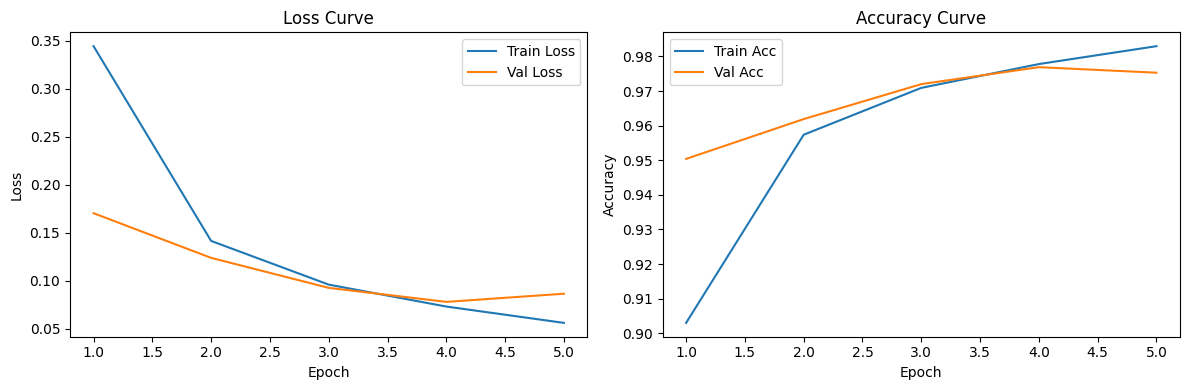

In [19]:
#plotting loss & accuracy curves

import matplotlib.pyplot as plt

epochs = range (1 , num_epochs+1)


plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(epochs, history['train_loss'], label='Train Loss')
plt.plot(epochs, history['val_loss'],   label='Val Loss')
plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.legend(); plt.title('Loss Curve')

plt.subplot(1,2,2)
plt.plot(epochs, history['train_acc'], label='Train Acc')
plt.plot(epochs, history['val_acc'],   label='Val Acc')
plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.legend(); plt.title('Accuracy Curve')

plt.tight_layout()
plt.show()


**VISUALIZING SOME PREDICTIONS**

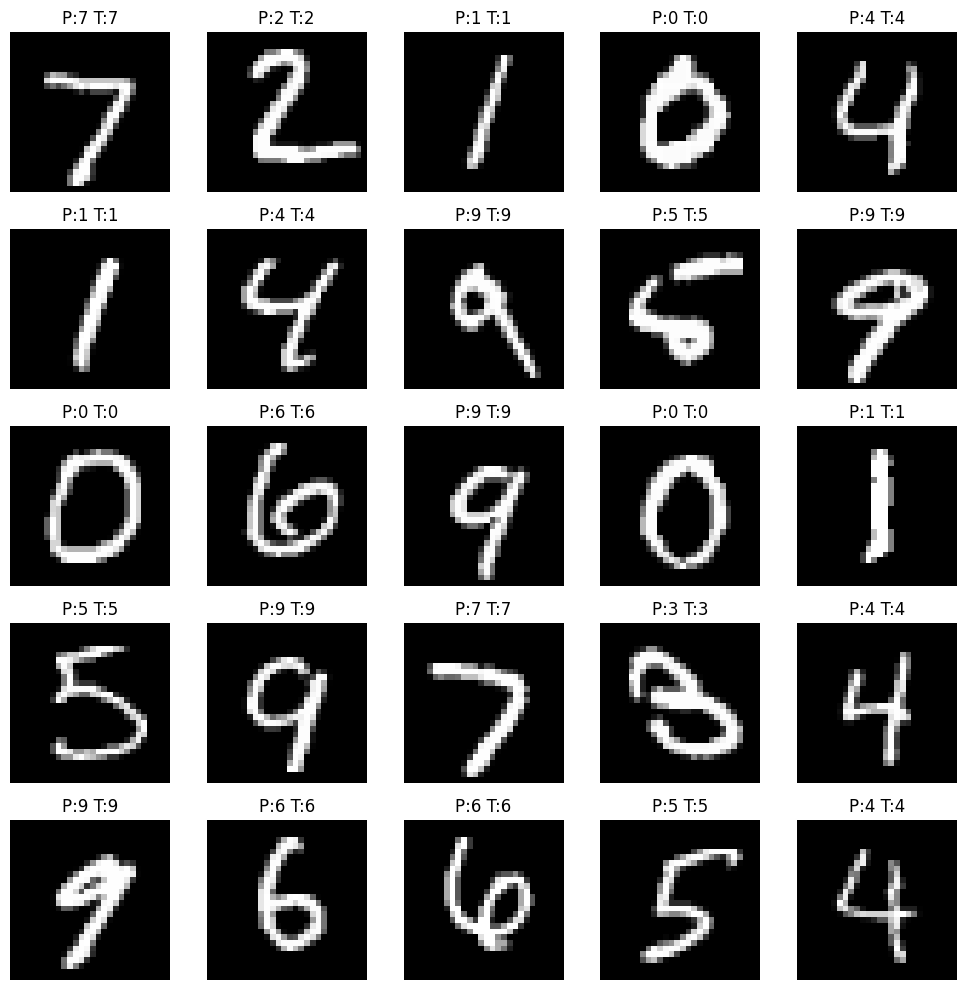

In [20]:
import matplotlib.pyplot as plt

model.eval()

X_batch, y_batch = next(iter(test_loader))
X_batch, y_batch = X_batch.to(device) , y_batch.to(device)
 
with torch.no_grad():
    logits = model(X_batch)
    preds = torch.argmax(logits, dim =1)

# Plot 25 images with predicted and true labels
plt.figure(figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.imshow(X_batch[i].cpu().squeeze(), cmap='gray')
    plt.title(f"P:{preds[i].item()} T:{y_batch[i].item()}")
    plt.axis('off')
plt.tight_layout()
plt.show()

In [21]:
#saving our trained model

torch.save(model.state_dict(), 'mnist_model.pt')

In [22]:
#to use our saved model later
model.load_state_dict(torch.load('mnist_model.pt'))
model.eval

<bound method Module.eval of Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=128, bias=True)
  (2): ReLU()
  (3): Linear(in_features=128, out_features=64, bias=True)
  (4): ReLU()
  (5): Linear(in_features=64, out_features=10, bias=True)
)>